In [1]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from Models.selective_sequential import *
from Loss.triplet_regularized import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
from session import LossMeter, EvalModel
from Layers.flatten import Flatten

%load_ext autoreload
%autoreload 2

torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='/media/drake/MX500/Datasets/cifar-10/train', train=True,
                                        download=True, transform=transform_train)
partial_trainset = torch.utils.data.dataset.Subset(trainset, np.arange(3200))

valset = torchvision.datasets.CIFAR10(root='/media/drake/MX500/Datasets/cifar-10/test', train=False,
                                       download=True, transform=transform_test)
partial_valset = torch.utils.data.dataset.Subset(valset, np.arange(3200))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
select = ['max1', 'act1', 'out']
model = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(3, 64, kernel_size=5, padding=2),
     'act64': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),
     'act192': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),
     'act384': nn.ReLU(True),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),
     'act256a': nn.ReLU(True),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),
     'act256b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'fc1': nn.Linear(4 * 4 * 256, 512),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [4]:
criterion = TripletRegularizedMultiMarginLoss(0, .5)
sess = Session(model, criterion, optim.Adam, 1e-4)

In [5]:
validator = EmbeddingSpaceValidator(valloader, len(select)-1, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader), T_mult=1, lr_min=1e-7)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])
sess.train(schedule, 63)

Validating: 100%|██████████| 157/157 [00:06<00:00, 25.42it/s]


val accuracy:  0.401 
train loss:  0.3784  train BCE :  1.8313 
valid loss:  0.3649  valid BCE :  1.6407


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.50it/s]


val accuracy:  0.4876 
train loss:  0.3069  train BCE :  1.5854 
valid loss:  0.2933  valid BCE :  1.4607


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.68it/s]


val accuracy:  0.5345 
train loss:  0.2701  train BCE :  1.4607 
valid loss:  0.2547  valid BCE :  1.3493


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.49it/s]


val accuracy:  0.5723 
train loss:  0.2353  train BCE :  1.3685 
valid loss:  0.2253  valid BCE :  1.259


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.39it/s]


val accuracy:  0.6014 
train loss:  0.2062  train BCE :  1.293 
valid loss:  0.2056  valid BCE :  1.1811


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.87it/s]


val accuracy:  0.6301 
train loss:  0.1944  train BCE :  1.2276 
valid loss:  0.1883  valid BCE :  1.1148


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.70it/s]


val accuracy:  0.6464 
train loss:  0.1824  train BCE :  1.1777 
valid loss:  0.1756  valid BCE :  1.0691


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.71it/s]


val accuracy:  0.6566 
train loss:  0.1646  train BCE :  1.1243 
valid loss:  0.1662  valid BCE :  1.0318


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.79it/s]


val accuracy:  0.6768 
train loss:  0.156  train BCE :  1.0805 
valid loss:  0.1553  valid BCE :  0.9857


Validating: 100%|██████████| 157/157 [00:06<00:00, 26.15it/s]


val accuracy:  0.6858 
train loss:  0.1444  train BCE :  1.0478 
valid loss:  0.1486  valid BCE :  0.9587


Validating: 100%|██████████| 157/157 [00:05<00:00, 26.19it/s]


val accuracy:  0.7033 
train loss:  0.1411  train BCE :  0.9991 
valid loss:  0.1387  valid BCE :  0.9165


Validating: 100%|██████████| 157/157 [00:05<00:00, 26.27it/s]


val accuracy:  0.7103 
train loss:  0.1299  train BCE :  0.9687 
valid loss:  0.1338  valid BCE :  0.8965


Validating: 100%|██████████| 157/157 [00:05<00:00, 26.29it/s]


val accuracy:  0.7219 
train loss:  0.1203  train BCE :  0.928 
valid loss:  0.1276  valid BCE :  0.8554


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.07it/s]


val accuracy:  0.7351 
train loss:  0.1188  train BCE :  0.9022 
valid loss:  0.1209  valid BCE :  0.8271


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.88it/s]


val accuracy:  0.7461 
train loss:  0.1089  train BCE :  0.8784 
valid loss:  0.116  valid BCE :  0.8122


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.11it/s]


val accuracy:  0.7542 
train loss:  0.107  train BCE :  0.8536 
valid loss:  0.1121  valid BCE :  0.79


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.94it/s]


val accuracy:  0.7615 
train loss:  0.1049  train BCE :  0.8254 
valid loss:  0.1076  valid BCE :  0.7616


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.97it/s]


val accuracy:  0.7672 
train loss:  0.094  train BCE :  0.8028 
valid loss:  0.1046  valid BCE :  0.7459


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.93it/s]


val accuracy:  0.7695 
train loss:  0.094  train BCE :  0.7761 
valid loss:  0.1024  valid BCE :  0.7214


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.89it/s]


val accuracy:  0.7741 
train loss:  0.0891  train BCE :  0.7601 
valid loss:  0.0991  valid BCE :  0.7127


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.87it/s]


val accuracy:  0.7851 
train loss:  0.0813  train BCE :  0.7355 
valid loss:  0.0958  valid BCE :  0.6874


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.95it/s]


val accuracy:  0.7884 
train loss:  0.0825  train BCE :  0.7176 
valid loss:  0.0935  valid BCE :  0.6802


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.02it/s]


val accuracy:  0.7945 
train loss:  0.0792  train BCE :  0.7004 
valid loss:  0.0915  valid BCE :  0.6624


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.12it/s]


val accuracy:  0.7972 
train loss:  0.0789  train BCE :  0.6853 
valid loss:  0.0896  valid BCE :  0.6473


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.25it/s]


val accuracy:  0.7991 
train loss:  0.0734  train BCE :  0.672 
valid loss:  0.0882  valid BCE :  0.6397


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.92it/s]


val accuracy:  0.8016 
train loss:  0.0676  train BCE :  0.6512 
valid loss:  0.0866  valid BCE :  0.6278


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.21it/s]


val accuracy:  0.8085 
train loss:  0.0666  train BCE :  0.6348 
valid loss:  0.0843  valid BCE :  0.6174


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.22it/s]


val accuracy:  0.8108 
train loss:  0.064  train BCE :  0.6185 
valid loss:  0.0832  valid BCE :  0.6049


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.19it/s]


val accuracy:  0.8145 
train loss:  0.0621  train BCE :  0.6028 
valid loss:  0.0821  valid BCE :  0.5977


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.26it/s]


val accuracy:  0.8184 
train loss:  0.0618  train BCE :  0.5861 
valid loss:  0.0805  valid BCE :  0.5898


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.17it/s]


val accuracy:  0.8174 
train loss:  0.0588  train BCE :  0.5758 
valid loss:  0.0796  valid BCE :  0.5806


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.37it/s]


val accuracy:  0.8194 
train loss:  0.0554  train BCE :  0.5578 
valid loss:  0.0782  valid BCE :  0.5665


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.27it/s]


val accuracy:  0.824 
train loss:  0.0536  train BCE :  0.5427 
valid loss:  0.0773  valid BCE :  0.5548


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.27it/s]


val accuracy:  0.8263 
train loss:  0.053  train BCE :  0.531 
valid loss:  0.0761  valid BCE :  0.5495


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.35it/s]


val accuracy:  0.8255 
train loss:  0.0491  train BCE :  0.5219 
valid loss:  0.0754  valid BCE :  0.5432


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.19it/s]


val accuracy:  0.8254 
train loss:  0.047  train BCE :  0.5096 
valid loss:  0.0753  valid BCE :  0.5383


Validating: 100%|██████████| 157/157 [00:05<00:00, 27.77it/s]


val accuracy:  0.8274 
train loss:  0.0445  train BCE :  0.489 
valid loss:  0.0752  valid BCE :  0.5301


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.38it/s]


val accuracy:  0.8327 
train loss:  0.0428  train BCE :  0.4799 
valid loss:  0.074  valid BCE :  0.5182


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.32it/s]


val accuracy:  0.832 
train loss:  0.0404  train BCE :  0.4738 
valid loss:  0.0737  valid BCE :  0.5172


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.23it/s]


val accuracy:  0.8336 
train loss:  0.043  train BCE :  0.4629 
valid loss:  0.0736  valid BCE :  0.5124


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.46it/s]


val accuracy:  0.8331 
train loss:  0.0401  train BCE :  0.4528 
valid loss:  0.0724  valid BCE :  0.5034


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.16it/s]


val accuracy:  0.8324 
train loss:  0.0372  train BCE :  0.4357 
valid loss:  0.0718  valid BCE :  0.4955


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.20it/s]


val accuracy:  0.8379 
train loss:  0.0339  train BCE :  0.4278 
valid loss:  0.0711  valid BCE :  0.4965


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.54it/s]


val accuracy:  0.8407 
train loss:  0.0363  train BCE :  0.4131 
valid loss:  0.0706  valid BCE :  0.486


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.35it/s]


val accuracy:  0.8393 
train loss:  0.0347  train BCE :  0.4077 
valid loss:  0.0709  valid BCE :  0.483


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.25it/s]


val accuracy:  0.8425 
train loss:  0.0341  train BCE :  0.3961 
valid loss:  0.0699  valid BCE :  0.4787


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.32it/s]


val accuracy:  0.8413 
train loss:  0.03  train BCE :  0.3897 
valid loss:  0.07  valid BCE :  0.4797


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.42it/s]


val accuracy:  0.8402 
train loss:  0.0287  train BCE :  0.3816 
valid loss:  0.0698  valid BCE :  0.4733


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.20it/s]


val accuracy:  0.8443 
train loss:  0.0266  train BCE :  0.3681 
valid loss:  0.0701  valid BCE :  0.4683


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.23it/s]


val accuracy:  0.8441 
train loss:  0.0277  train BCE :  0.3645 
valid loss:  0.0696  valid BCE :  0.468


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.23it/s]


val accuracy:  0.8465 
train loss:  0.0262  train BCE :  0.3542 
valid loss:  0.0711  valid BCE :  0.464


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.32it/s]


val accuracy:  0.8491 
train loss:  0.0243  train BCE :  0.345 
valid loss:  0.0687  valid BCE :  0.4567


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.33it/s]


val accuracy:  0.8483 
train loss:  0.0248  train BCE :  0.3392 
valid loss:  0.0685  valid BCE :  0.4557


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.36it/s]


val accuracy:  0.8472 
train loss:  0.0219  train BCE :  0.3292 
valid loss:  0.0698  valid BCE :  0.4569


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.36it/s]


val accuracy:  0.8484 
train loss:  0.0214  train BCE :  0.3147 
valid loss:  0.0685  valid BCE :  0.4496


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.31it/s]


val accuracy:  0.8483 
train loss:  0.022  train BCE :  0.3084 
valid loss:  0.0693  valid BCE :  0.4454


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.31it/s]


val accuracy:  0.8494 
train loss:  0.0203  train BCE :  0.3039 
valid loss:  0.0701  valid BCE :  0.4458


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.44it/s]


val accuracy:  0.8474 
train loss:  0.0199  train BCE :  0.3016 
valid loss:  0.0694  valid BCE :  0.4467


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.38it/s]


val accuracy:  0.8485 
train loss:  0.0191  train BCE :  0.282 
valid loss:  0.07  valid BCE :  0.4406


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.32it/s]


val accuracy:  0.8484 
train loss:  0.0177  train BCE :  0.2842 
valid loss:  0.0699  valid BCE :  0.4445


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.27it/s]


val accuracy:  0.8532 
train loss:  0.0157  train BCE :  0.2747 
valid loss:  0.0683  valid BCE :  0.4349


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.39it/s]


val accuracy:  0.8511 
train loss:  0.0153  train BCE :  0.268 
valid loss:  0.0693  valid BCE :  0.4363


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.19it/s]


val accuracy:  0.8508 
train loss:  0.0153  train BCE :  0.259 
valid loss:  0.0706  valid BCE :  0.4353



In [6]:
validator.num_embeddings=1

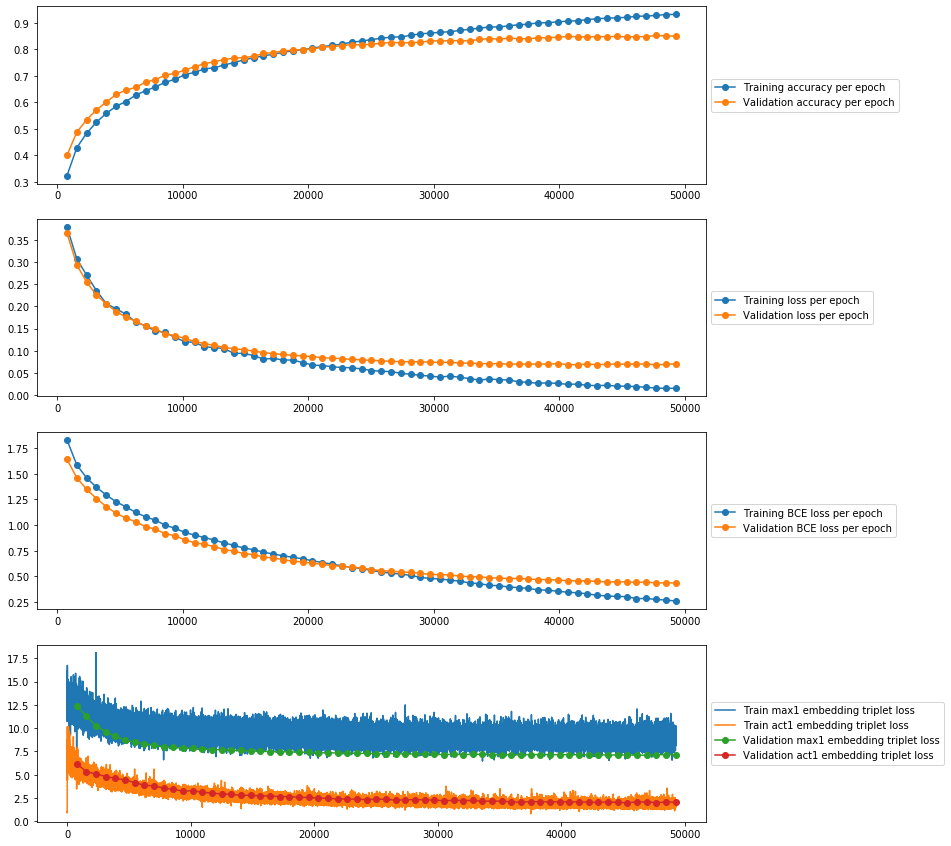

In [7]:
validator.plot()

In [8]:
print(np.max(validator.val_accuracies), " Best validation accuracy without reg")
print(np.max(validator.train_accuracies), " Best train accuracy without reg")

0.8532  Best validation accuracy without reg
0.93224  Best train accuracy without reg


In [20]:
select = ['act1', 'out']
model2 = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(3, 64, kernel_size=5, padding=2),
     'act64': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),
     'act192': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),
     'act384': nn.ReLU(True),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),
     'act256a': nn.ReLU(True),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),
     'act256b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'fc1': nn.Linear(4 * 4 * 256, 512),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [21]:
criterion = TripletRegularizedMultiMarginLoss(0.05, .25)
sess = Session(model2, criterion, optim.AdamW, 1e-4)

In [22]:
validator2 = EmbeddingSpaceValidator(valloader, len(select)-1, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader), T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator2])

In [ ]:
sess.train(schedule, 63)

Validating: 100%|██████████| 157/157 [00:05<00:00, 29.53it/s]


val accuracy:  0.49 
train loss:  0.3944  train BCE :  1.8058 
valid loss:  0.3902  valid BCE :  1.5919


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.28it/s]


val accuracy:  0.5591 
train loss:  0.3182  train BCE :  1.5295 
valid loss:  0.3076  valid BCE :  1.4057


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.07it/s]


val accuracy:  0.6046 
train loss:  0.2615  train BCE :  1.3943 
valid loss:  0.261  valid BCE :  1.2842


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.97it/s]


val accuracy:  0.6381 
train loss:  0.2311  train BCE :  1.2978 
valid loss:  0.2308  valid BCE :  1.2031


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.05it/s]


val accuracy:  0.6694 
train loss:  0.2042  train BCE :  1.2102 
valid loss:  0.2065  valid BCE :  1.115


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.05it/s]


val accuracy:  0.6946 
train loss:  0.1907  train BCE :  1.1504 
valid loss:  0.1887  valid BCE :  1.0625


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.27it/s]


val accuracy:  0.7127 
train loss:  0.1761  train BCE :  1.088 
valid loss:  0.1746  valid BCE :  1.0021


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.16it/s]


val accuracy:  0.7235 
train loss:  0.1554  train BCE :  1.0384 
valid loss:  0.1646  valid BCE :  0.9691


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.05it/s]


val accuracy:  0.7406 
train loss:  0.1476  train BCE :  0.9947 
valid loss:  0.1521  valid BCE :  0.9231


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.18it/s]


val accuracy:  0.7488 
train loss:  0.1357  train BCE :  0.9509 
valid loss:  0.1448  valid BCE :  0.8824


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.29it/s]


val accuracy:  0.7592 
train loss:  0.1302  train BCE :  0.9174 
valid loss:  0.138  valid BCE :  0.8524


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.33it/s]


val accuracy:  0.7678 
train loss:  0.1194  train BCE :  0.886 
valid loss:  0.1322  valid BCE :  0.8259


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.27it/s]


val accuracy:  0.7767 
train loss:  0.1163  train BCE :  0.8534 
valid loss:  0.1268  valid BCE :  0.8059


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.24it/s]


val accuracy:  0.7839 
train loss:  0.1071  train BCE :  0.8279 
valid loss:  0.1224  valid BCE :  0.7897


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.13it/s]


val accuracy:  0.7913 
train loss:  0.1072  train BCE :  0.7942 
valid loss:  0.1174  valid BCE :  0.7496


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.18it/s]


val accuracy:  0.7982 
train loss:  0.1004  train BCE :  0.7627 
valid loss:  0.1142  valid BCE :  0.7377


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.13it/s]


val accuracy:  0.8006 
train loss:  0.0932  train BCE :  0.7459 
valid loss:  0.1116  valid BCE :  0.7243


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.20it/s]


val accuracy:  0.804 
train loss:  0.089  train BCE :  0.7233 
valid loss:  0.1086  valid BCE :  0.7034


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.82it/s]


val accuracy:  0.8124 
train loss:  0.0841  train BCE :  0.6967 
valid loss:  0.1051  valid BCE :  0.6933


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.18it/s]


val accuracy:  0.8116 
train loss:  0.0817  train BCE :  0.6708 
valid loss:  0.1045  valid BCE :  0.6768


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.27it/s]


val accuracy:  0.8203 
train loss:  0.071  train BCE :  0.6499 
valid loss:  0.1025  valid BCE :  0.657


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.26it/s]


val accuracy:  0.8183 
train loss:  0.0751  train BCE :  0.6341 
valid loss:  0.1012  valid BCE :  0.6508


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.15it/s]


val accuracy:  0.821 
train loss:  0.0689  train BCE :  0.6178 
valid loss:  0.1  valid BCE :  0.6424


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.16it/s]


val accuracy:  0.8255 
train loss:  0.0668  train BCE :  0.6017 
valid loss:  0.0973  valid BCE :  0.6315


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.37it/s]


val accuracy:  0.8255 
train loss:  0.0638  train BCE :  0.5819 
valid loss:  0.0966  valid BCE :  0.626


In [13]:
w = list(model2.parameters())
w

[Parameter containing:
 tensor([[[[-1.2104e-02,  2.9573e-02, -2.8922e-02,  1.7594e-02,  5.1013e-03],
           [ 5.7761e-04,  1.4556e-02,  6.2851e-03, -2.9522e-02, -1.1761e-02],
           [ 1.0226e-02, -3.6977e-02,  2.2658e-02,  3.4213e-02,  3.1562e-04],
           [ 3.5423e-02, -1.8281e-02,  9.4915e-03, -4.0875e-02,  1.2320e-02],
           [-3.7341e-02,  3.3254e-02, -3.0205e-02,  5.3110e-02, -2.0229e-02]],
 
          [[ 2.6071e-02, -5.2731e-02,  1.2806e-02,  3.1245e-02, -3.2052e-02],
           [ 2.0855e-02, -7.2150e-03,  3.7356e-02, -3.8027e-02,  3.2431e-02],
           [-3.7974e-02,  3.5600e-02, -4.1973e-02,  1.1265e-02, -1.9344e-02],
           [-3.5255e-02,  3.0654e-02,  6.3281e-03,  3.7997e-03,  2.3422e-02],
           [ 3.8782e-02, -1.6702e-02, -3.1514e-04, -1.5874e-02,  2.7593e-03]],
 
          [[-2.0347e-02,  4.1961e-02,  1.0234e-02, -5.3832e-02,  3.2929e-02],
           [-1.0510e-02, -1.4073e-02, -3.1398e-02,  6.6344e-02, -3.0675e-02],
           [ 1.3307e-02,  3.2171e-0

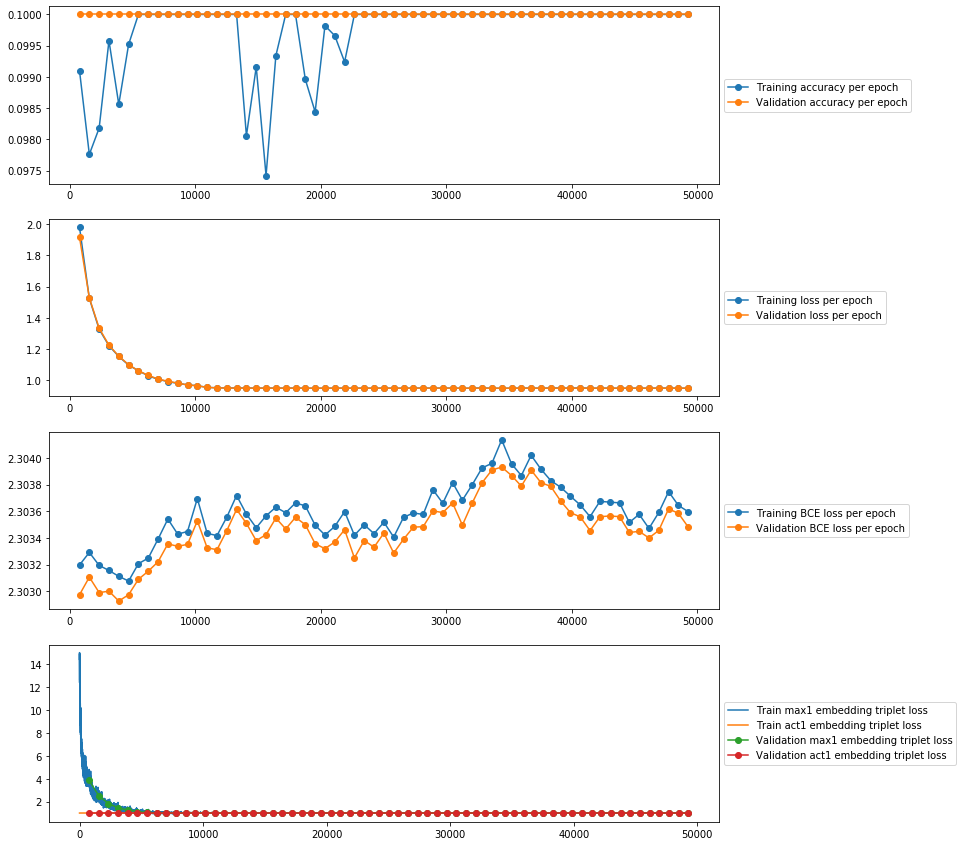

In [14]:
validator2.plot()

In [15]:
print(np.max(validator2.val_accuracies), "Best accuracy with reg")
print(np.max(validator.val_accuracies), "Best accuracy without reg")

0.1 Best accuracy with reg
0.8532 Best accuracy without reg
